In [1]:
%%html
<style type="text/css">
input.good:checked + label {color: green}
input.bad:checked + label {color: red}
input.good:checked + label::after {color: green; content: ' Õige vastus!'}
input.bad:checked + label::after {color: red; content: ' Vale vastus!'}

.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Mittelineaarse Pohli ringpendli simulatsioon

See tööleht näitab, kuidas saab simuleerida [Pohl'i ringpendli lisaraskuse ja välisjõuga](http://iopscience.iop.org/article/10.1088/0143-0807/35/5/055012), mis tekitab mittelineaarset võnkumist. Pendli liikumisvõrrandite lahendamiseks kasutame SciPy ja NumPy, tulemuste joonistamiseks kasutame PyPlot.

In [2]:
%matplotlib inline

from scipy.integrate import odeint
from scipy.io import wavfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import multiprocessing as mp

Jooniste suurus:

In [3]:
plt.rc('figure', figsize=(10.0, 7.5))

## Pendli definitsioon

Pohli ringpendli kirjeldab selline mitteautonoomne liikumisvõrrand:

\begin{align}
\dot{x} &= v\\
\dot{v} &= \frac{1}{I}\{m \sin(x) - k[x - A\cos(\omega t)] - hv\}
\end{align}

Dünaamilised muutujad on pendli asukoht $x$ ja kiirus $v$. Dünaamika sõltub konstantidest:

* inertsimoment $I$
* veedru parameeter $k$
* hõõrdetegur $h$
* ajamisjõu amplituud $A$
* ajamisjõu sagedus $\omega$
* lisamass $m$

Kui me defineerime $\phi = \omega t$, võime pendli ka kolmemõõtmelise autonoomse süsteemina kirjeldada. Sel juhul on liikumisvõrrandid:

\begin{align}
\dot{x} &= v\\
\dot{v} &= \frac{1}{I}\{m \sin(x) - k[x - A\cos(\phi)] - hv\}\\
\dot{\phi} &= \omega
\end{align}

Lisaks on algitingimuseks $\phi(0) = 0$. Mõned sobilikud konstantide väärtused on näiteks sellised:

In [4]:
defparam = {
# lisamass
    'mass': 0.027,
# inertsimoment
    'inertia': 0.0022,
# veedru parameeter
    'spring': 0.025,
# ajamisjõu amplituud
    'ampl': 5.5 * np.pi / 180,
# ajamisjõu sagedus
    'freq': 2.0 * np.pi / 4.2
}

Hõõrdejõuga võib katsetada - siin on mõned huvitavad väärtused:

In [5]:
dampvals = [0.003, 0.0027, 0.0025, 0.00249, 0.0024, 0.0022, 0.00215, 0.002, 0.0019, 0.0016, 0.00135, 0.001325, 0.00131, 0.0012, 0.00115, 0.001, 0.0008]

Nende abil võime nüüd ka pendli liikumisvõrrandi defineerida:

In [6]:
def pend(y, t, mass, inertia, spring, ampl, freq, damp):
    x, v = y
    dydt = [v, (mass * np.sin(x) - spring * (x - ampl * np.cos(freq * t)) - damp * v) / inertia]
    return dydt

Ilma hõõrde ja ajamisjõuta liigub pendel potentsiaalis, mida kirjeldab funktsioon

$$V(x) = m\cos(x) + \frac{1}{2}kx^2$$

In [7]:
def potf(x, mass, spring):
    return mass * np.cos(x) + spring * x**2 / 2

Kui me potentsiaali joonistame, näeme, et on olemas kaks miinimumi.

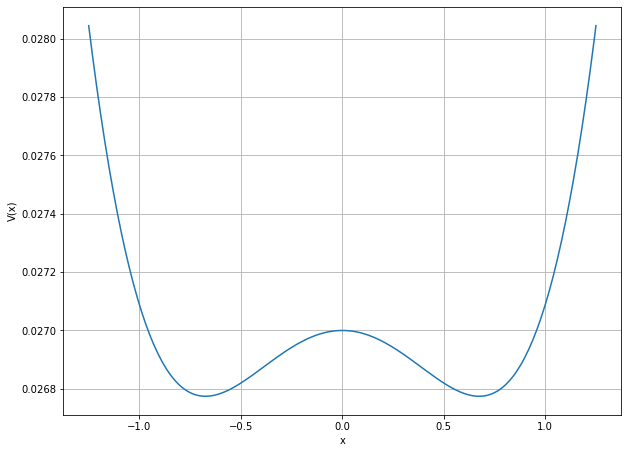

In [9]:
xv = np.linspace(-1.25, 1.25, 251)
pv = [potf(x, defparam['mass'], defparam['spring']) for x in xv]
plt.plot(xv, pv)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid()
plt.show()

## Liikumisvõrrandite lahendamine

Liikumisvõrrandite lahendamiseks on meil lisaks dünaamikale ka algtingimusi vaja. Siin eeldame et alguses, $t = 0$, kehtib $x(0) = 0$ ja $v(0) = 0$.

In [10]:
y0 = [0.0, 0.0]

Järgmisena valime, millises ajavahemikus me soovime võrrandeid lahendada. Vahemik on valitud nii, et kui pendli liikumist konverteeritakse helifailiks, mida mängitakse 1800 korda kiirem kui päris võnkumist, siis helifaili kestus on 12s. Sellest järeldub, et pendli simulatsiooni kestus on 21600s, ehk 6 tundi. Lisaks defineerime audio diskreetimissagedus (*sampling rate*), tavaline valik on 44100 (heli CD).

In [11]:
afreq = 441
smpper = 100
perplot = 25
perpre = 500
duration = 12

Nende konstantidega defineerime ajavahemiku $T = [t_0, t_1]$, milles liikumisvõrrandeid lahendada.

In [15]:
periods = duration * afreq
smprt = afreq * smpper
time = 2 * np.pi * periods / defparam['freq']
nsmp = smpper * perplot
presmp = smpper * perpre
samples = duration * smprt + 1
t = np.linspace(0, time, samples)
phi = np.linspace(0, 2 * np.pi, smpper + 1)

print("Simulatsiooni omadused:")
print("Ajamisjõu perioodide arv: %d" % periods)
print("Reaalaja kestus: %fs" % time)
print("Sammud perioodi kohta: %d" % smpper)
print("Sammud kokku: %d" % (samples - 1))
print()
print("Eelvõnkumine:")
print("Perioodide arv: %d" % perpre)
print("Reaalaeg: %fs" % (2 * np.pi * perpre / defparam['freq']))
print()
print("Jooniste omadused:")
print("Joonistatud perioodide arv: %d" % perplot)
print("Joonistatud reaalaeg: %fs" % (2 * np.pi * perplot / defparam['freq']))
print()
print("Helifaili omadused:")
print("Kuulamisaja kestus: %fs" % duration)
print("Diskreetimissagedus: %dHz" % smprt)
print("Baastooni helisagedus: %dHz" % afreq)

Simulatsiooni omadused:
Ajamisjõu perioodide arv: 5292
Reaalaja kestus: 22226.400000s
Sammud perioodi kohta: 100
Sammud kokku: 529200

Eelvõnkumine:
Perioodide arv: 500
Reaalaeg: 2100.000000s

Jooniste omadused:
Joonistatud perioodide arv: 25
Joonistatud reaalaeg: 105.000000s

Helifaili omadused:
Kuulamisaja kestus: 12.000000s
Diskreetimissagedus: 44100Hz
Baastooni helisagedus: 441Hz


Lõpuks kasutame SymPy funktsiooni ```odeint``` võrrandite lahendamiseks. Seda võib objektiklassina kirjutada, selleks et me saame hiljem mitu koopiat paralleelarvutuses käivitada.

In [16]:
class pendint(object):
    def __init__(self, y0, time, param, var):
        self.y0 = y0
        self.time = time
        self.param = param
        self.var = var
        
    def __call__(self, d):
        param = self.param
        param[self.var] = d
        return odeint(pend, self.y0, self.time, args = (param['mass'], param['inertia'], param['spring'], param['ampl'], param['freq'], param['damp']))

Siis käivitame arvutust iga hõõrdejõu parameetri väärtuse kohta.

In [17]:
dampint = pendint(y0, t, defparam, 'damp')

with mp.Pool() as pool:
    sols = dict(zip(dampvals, pool.map(dampint, dampvals)))

## Lahendite joonistamine

Saadud lahendeid võime erineval viisil joonistada.

### Aeg ja pendli asukoht

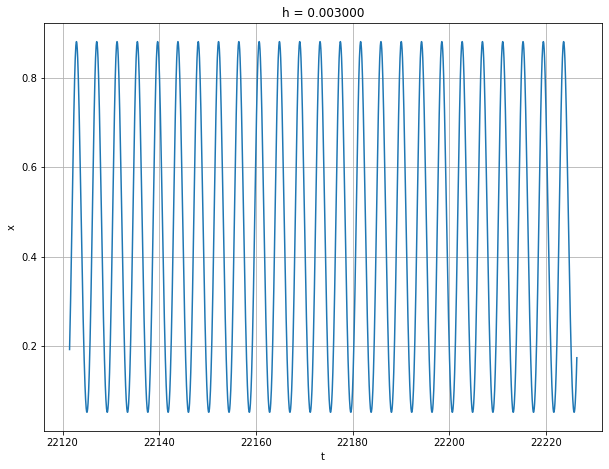

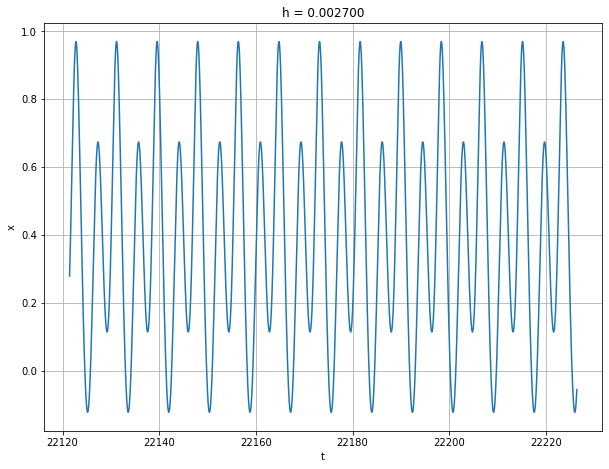

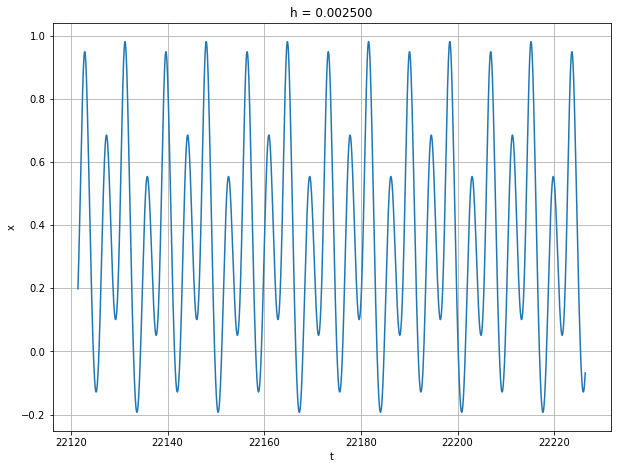

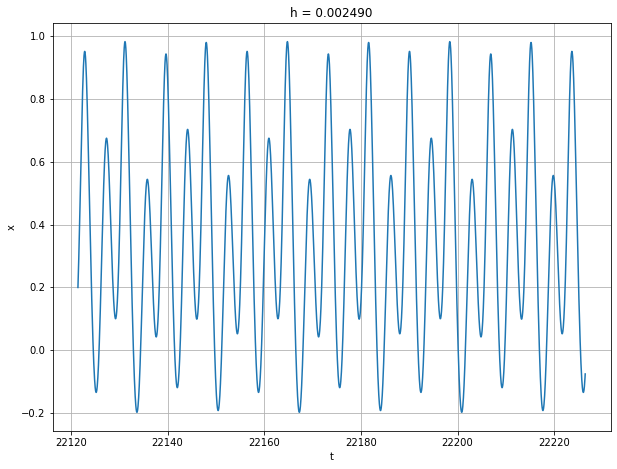

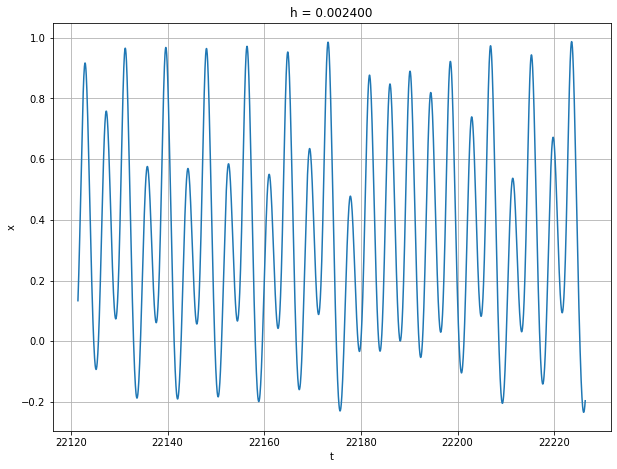

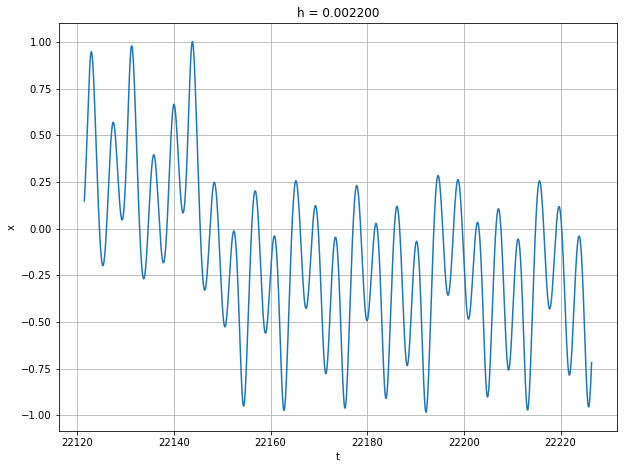

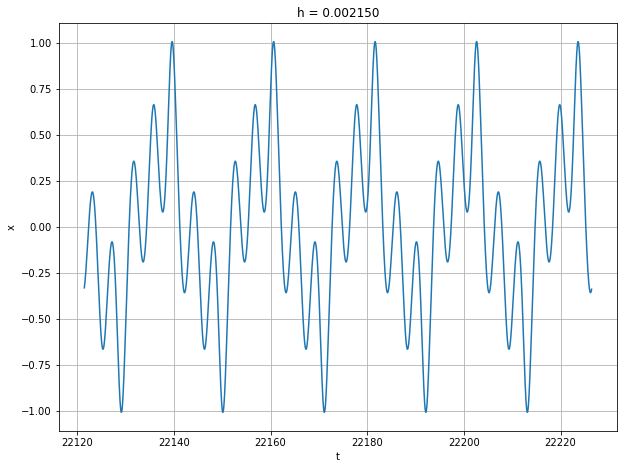

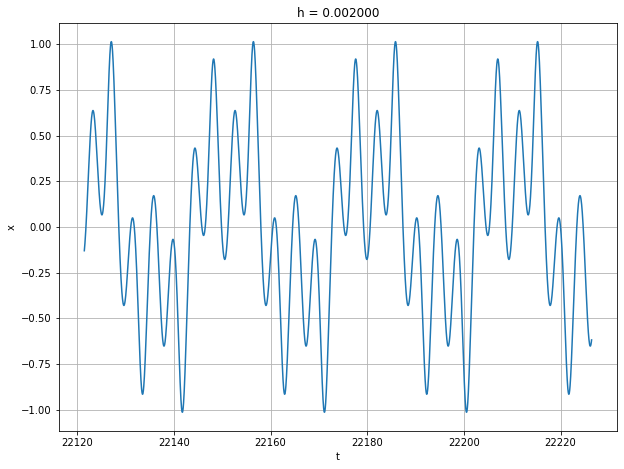

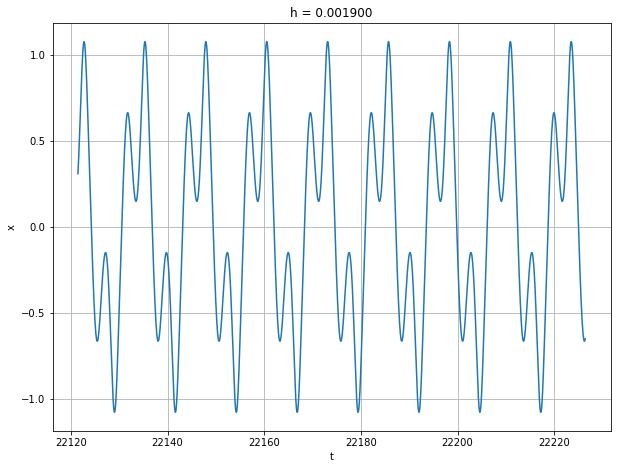

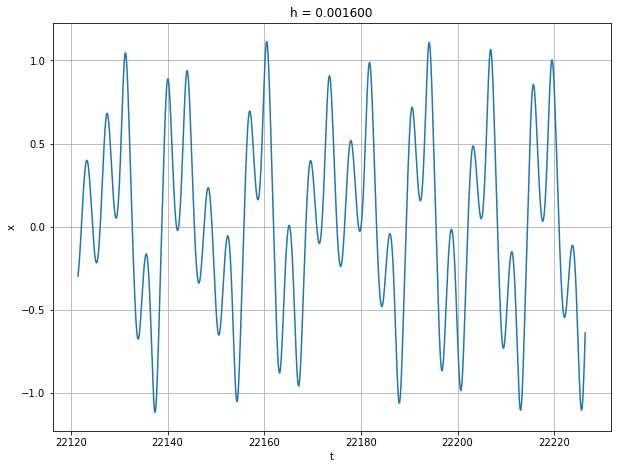

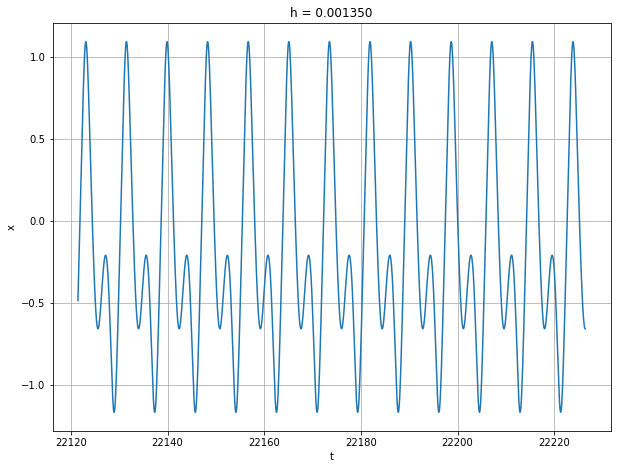

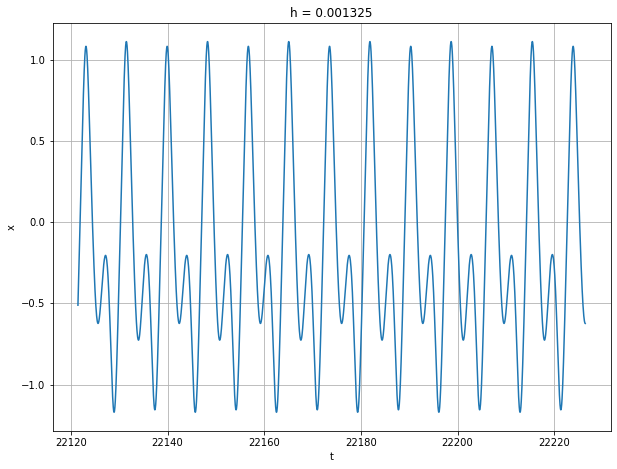

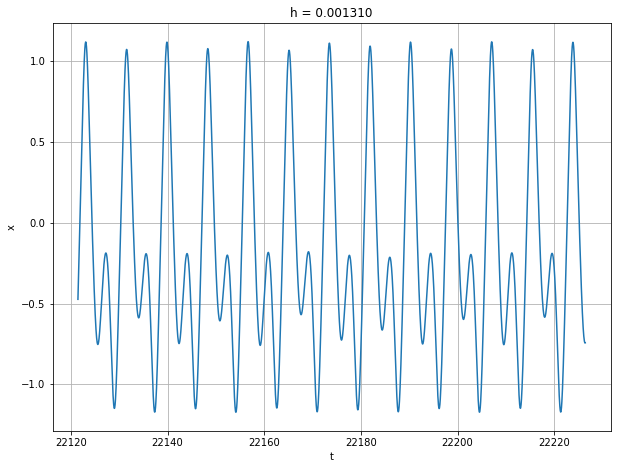

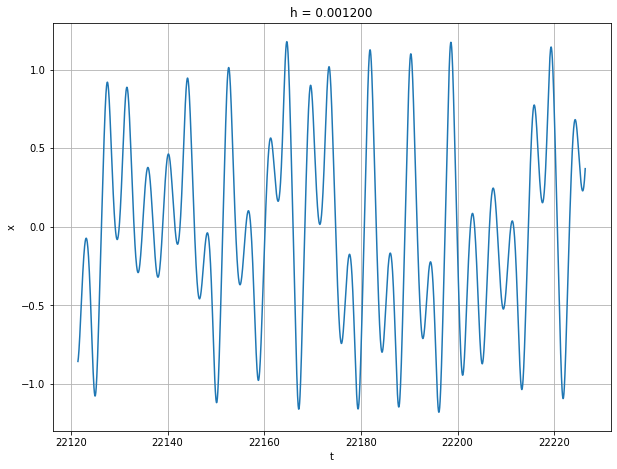

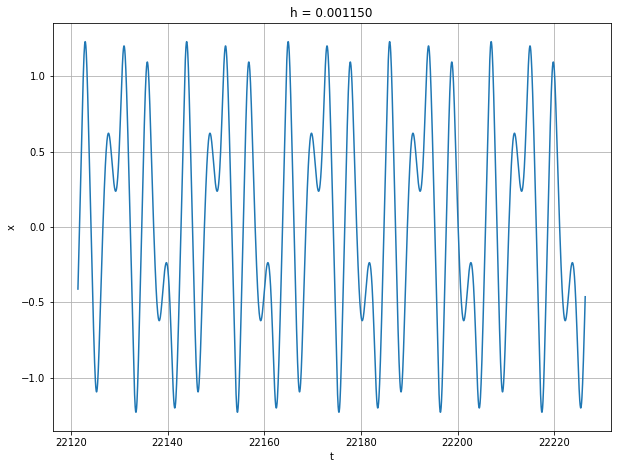

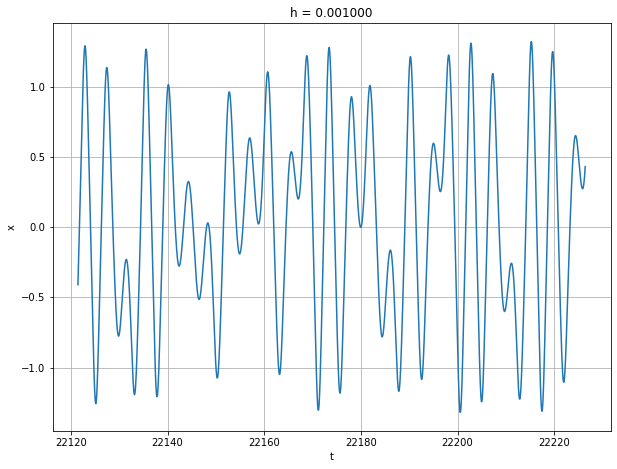

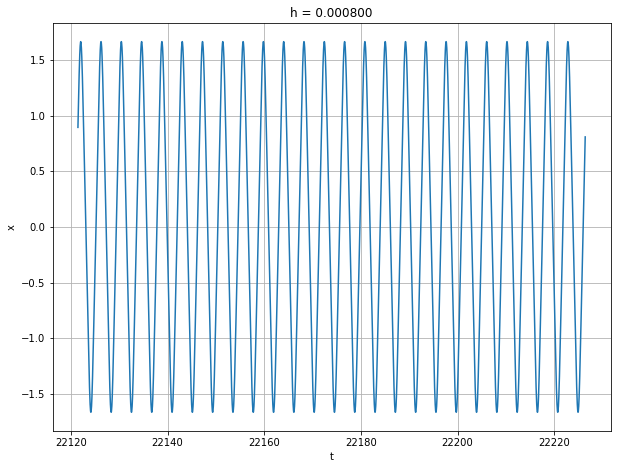

In [18]:
for damp, sol in sols.items():
    plt.plot(t[-nsmp:], sol[-nsmp:, 0])
    plt.title("h = %f" % damp)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid()
    plt.show()

### Pendli asukoht ja kiirus

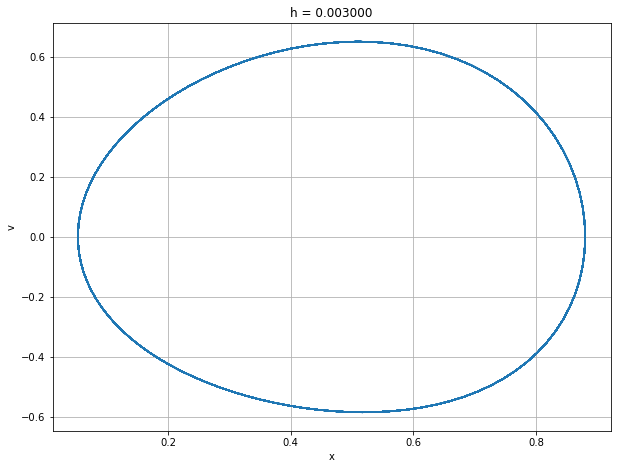

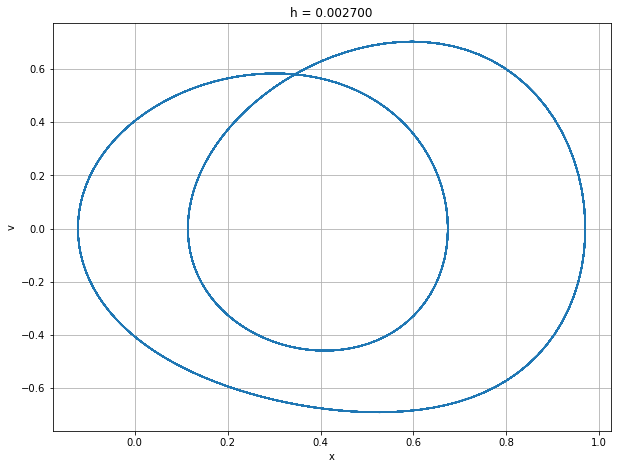

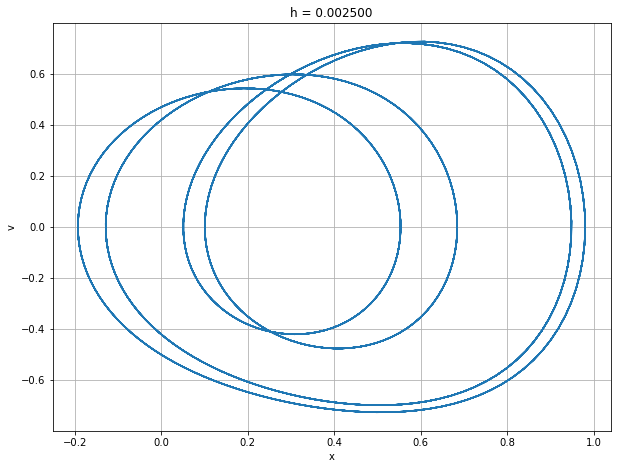

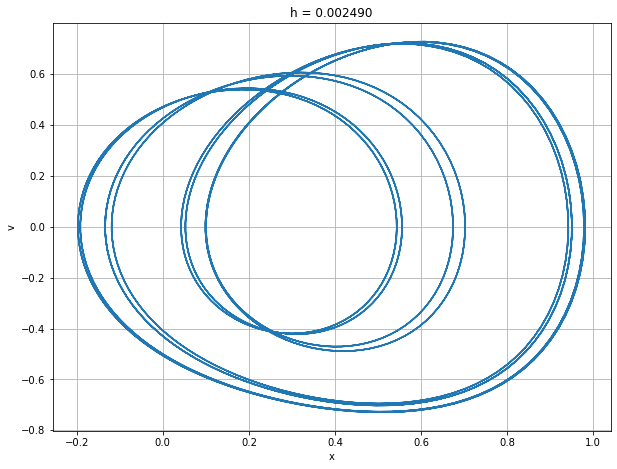

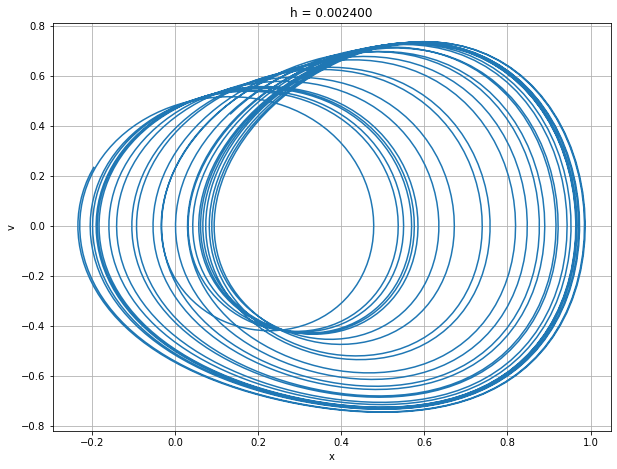

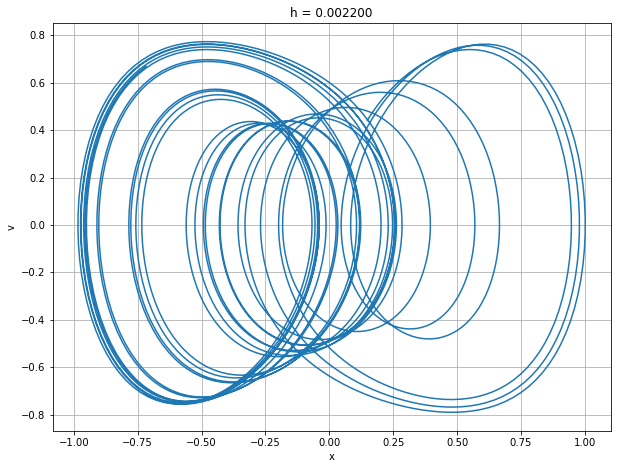

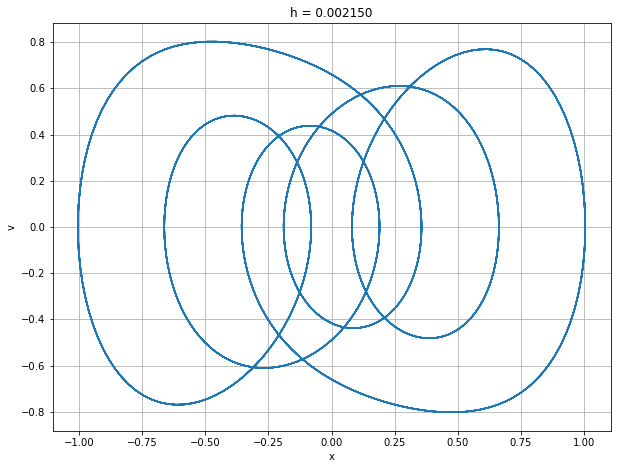

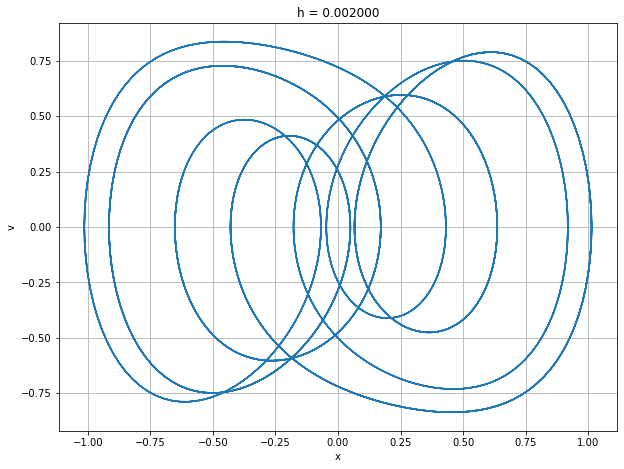

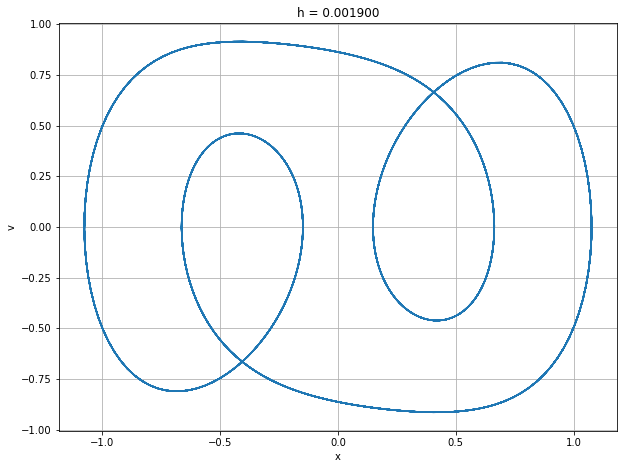

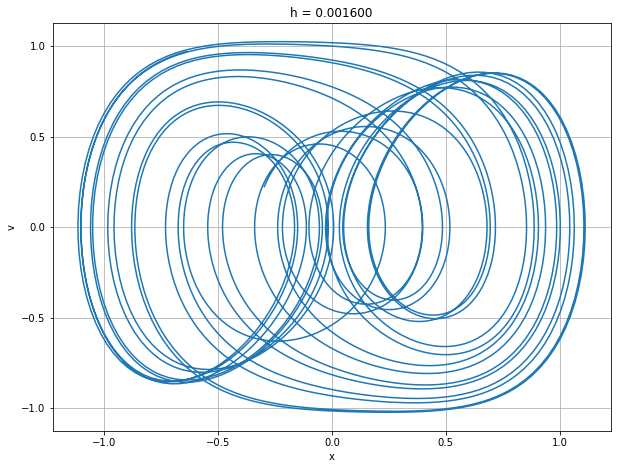

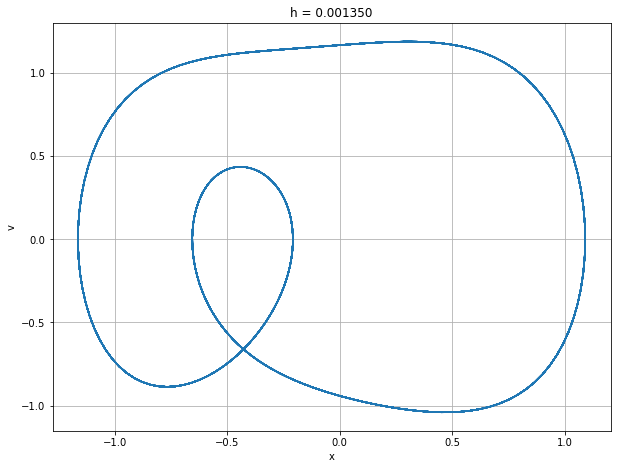

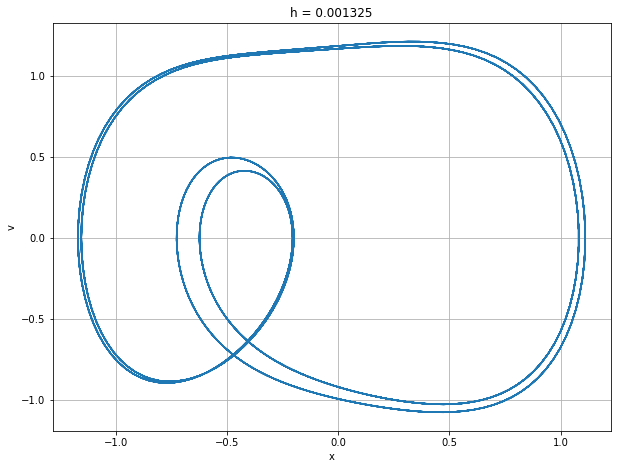

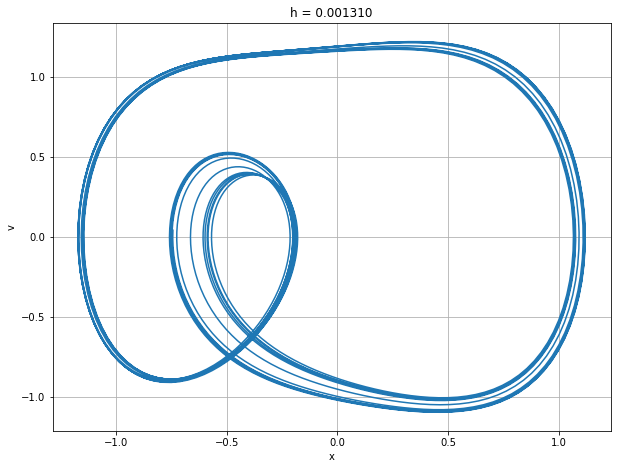

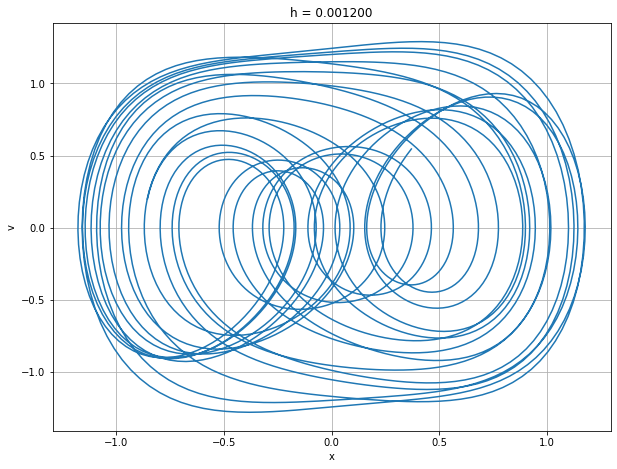

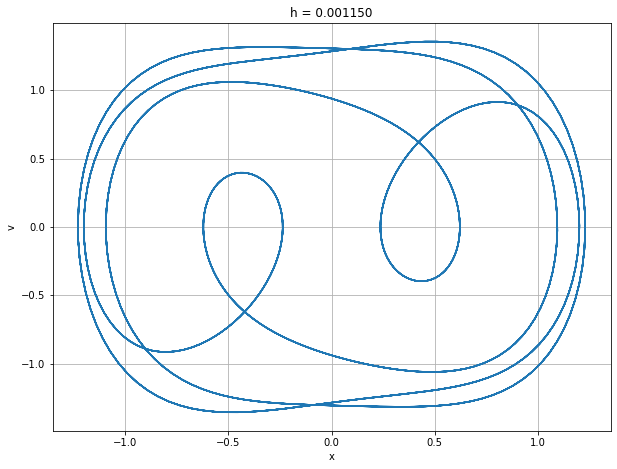

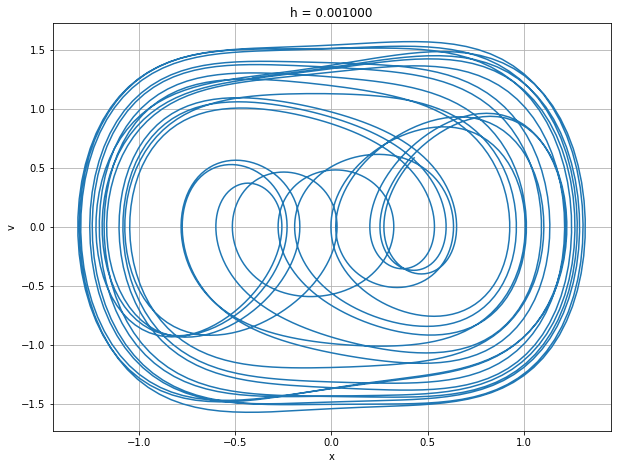

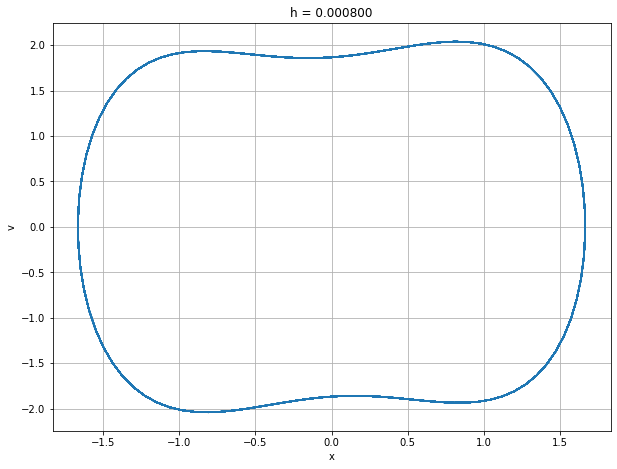

In [19]:
for damp, sol in sols.items():
    plt.plot(sol[-nsmp:, 0], sol[-nsmp:, 1])
    plt.title("h = %f" % damp)
    plt.xlabel("x")
    plt.ylabel("v")
    plt.grid()
    plt.show()

### Trajektoor faasiruumis

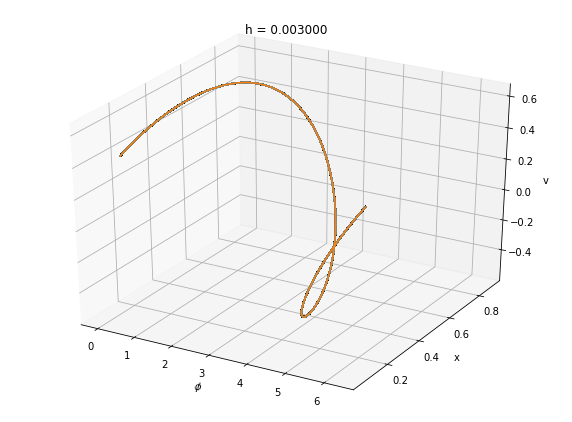

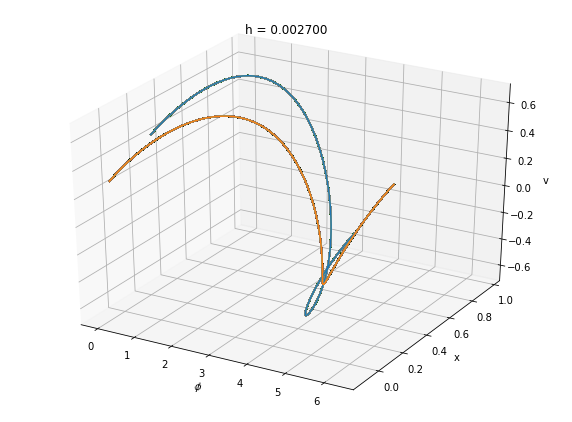

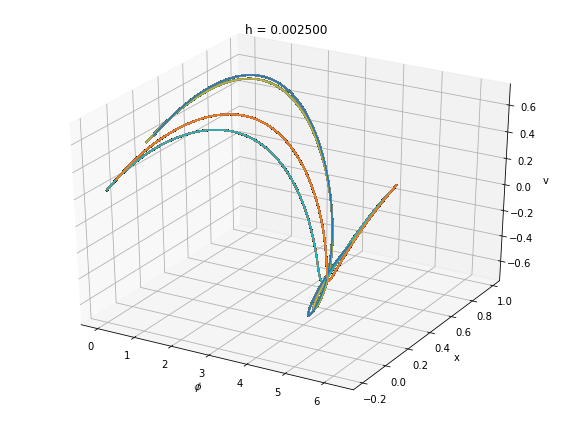

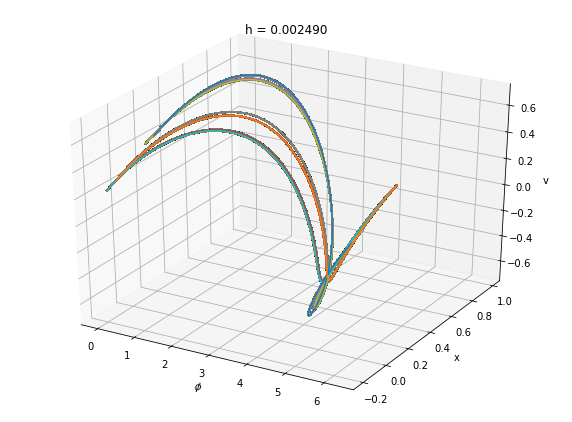

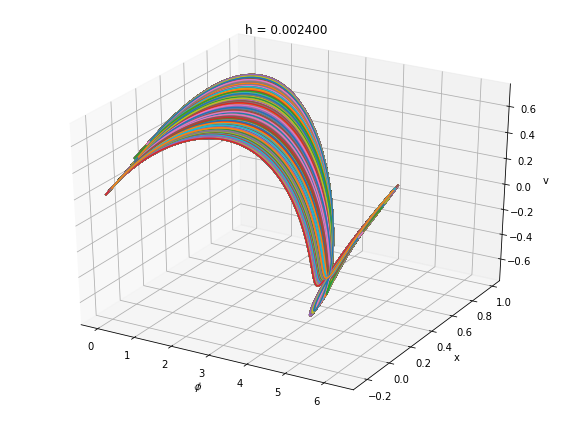

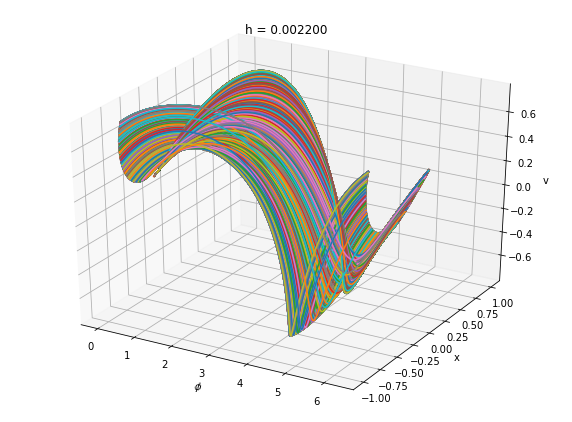

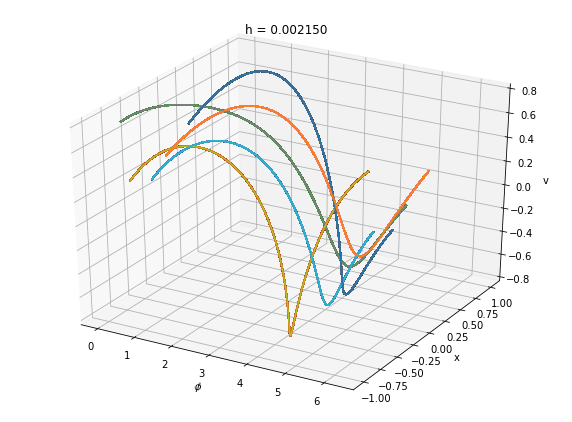

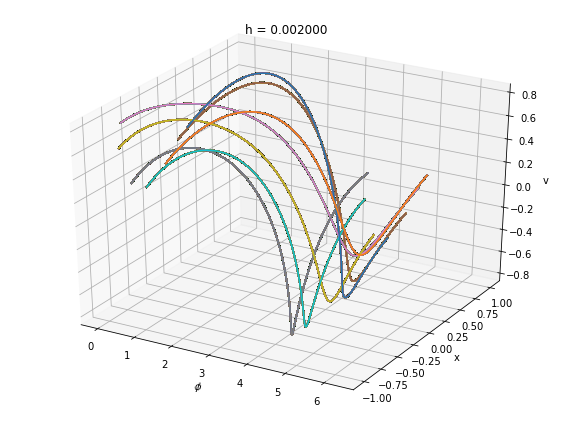

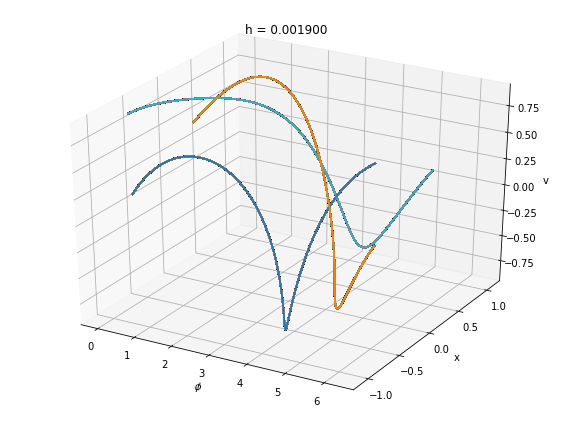

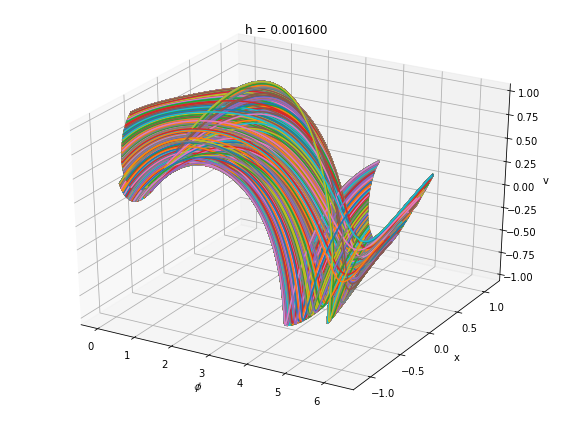

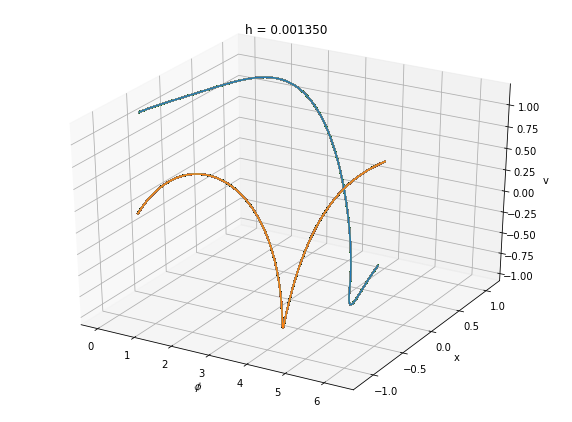

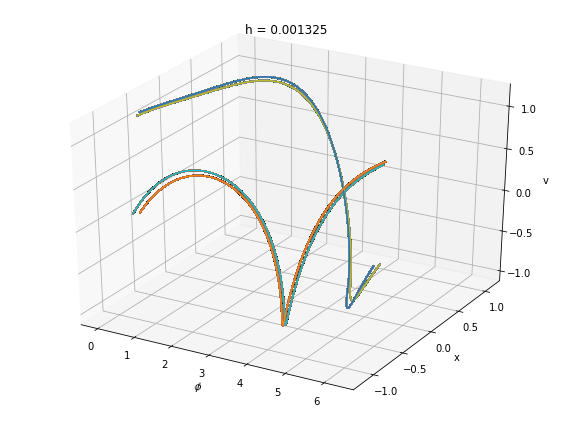

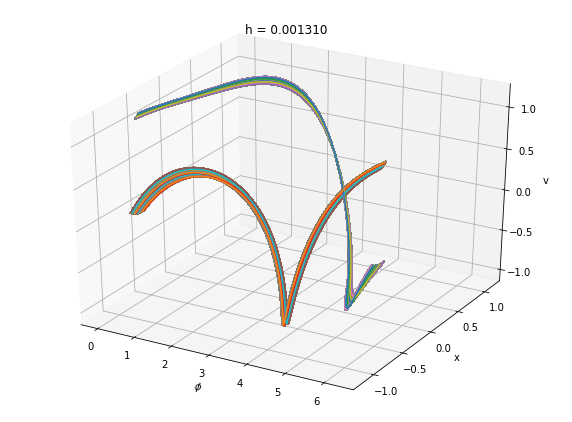

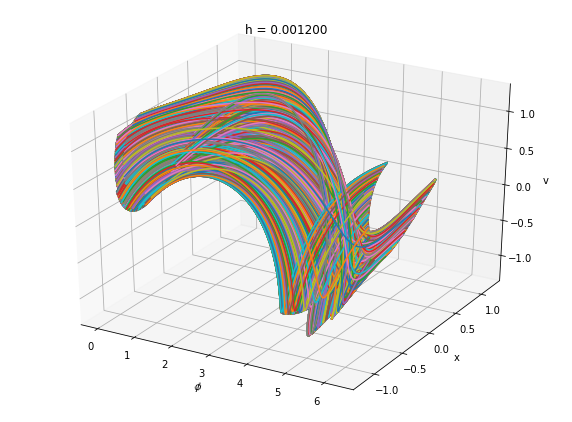

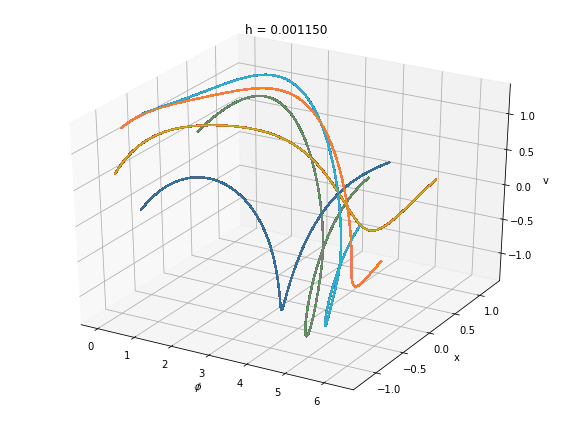

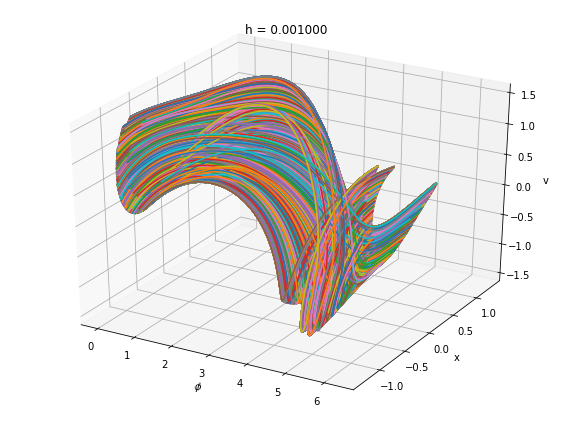

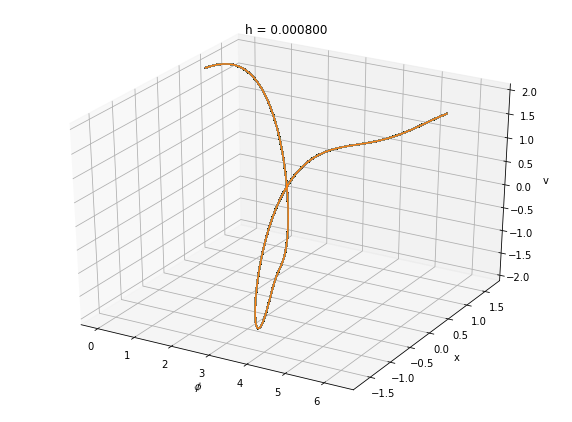

In [20]:
for damp, sol in sols.items():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    for n in range(periods - perpre):
        ax.plot(phi, sol[-(n + 1) * smpper - 2:-n * smpper - 1, 0], sol[-(n + 1) * smpper - 2:-n * smpper - 1, 1])
    ax.set_title("h = %f" % damp)
    ax.set_xlabel("$\\phi$")
    ax.set_ylabel("x")
    ax.set_zlabel("v")
    plt.show()

## Poincare lõige

Järgmisena joonistame Poincaré lõiget. Selleks jätame siirdeseisundi (näiteks 10000 sammu) simulatsiooni alguses ära, ja joonistame ainult seda osa, kui võnkumine on juba lähenenud stabiilsele olekule. Siis joonistame ainult ühe punkti igast generaatori perioodist, ehk igat 100. sammu. Poincaré lõige sõltub generaatori faasist.

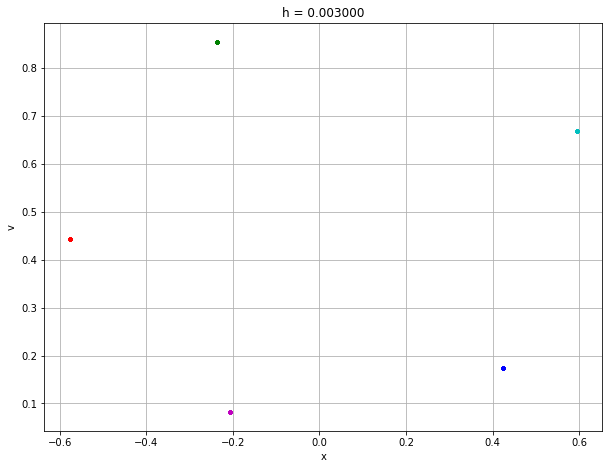

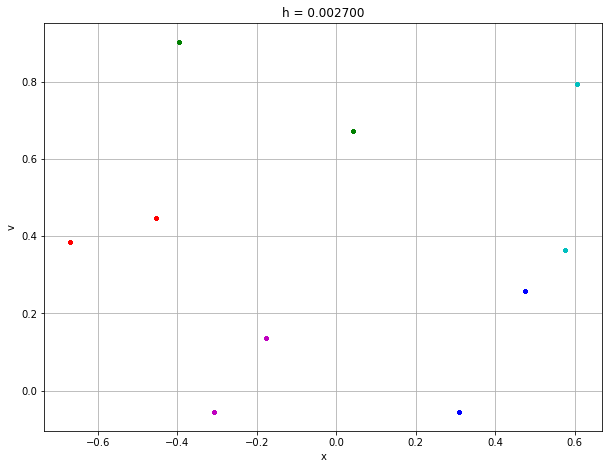

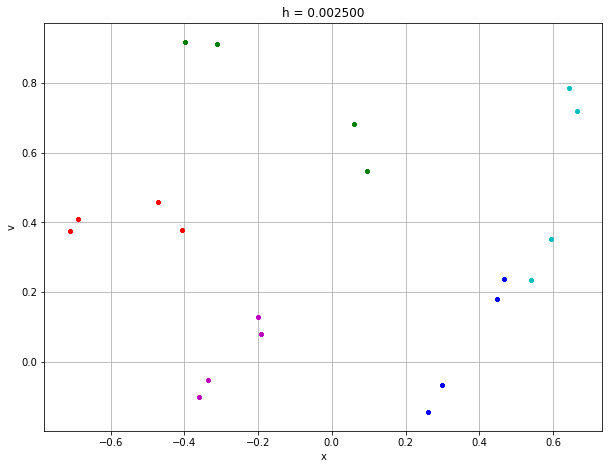

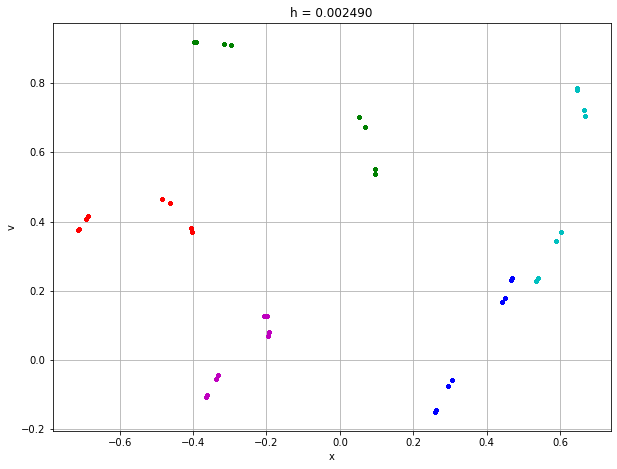

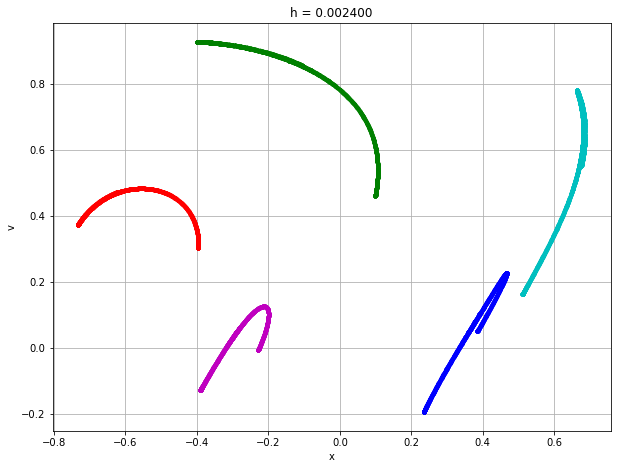

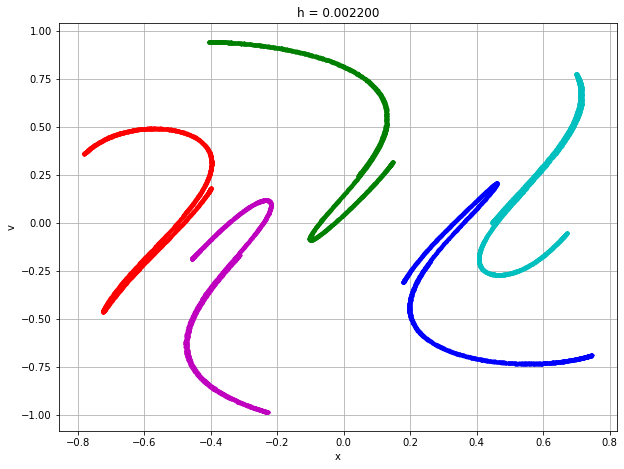

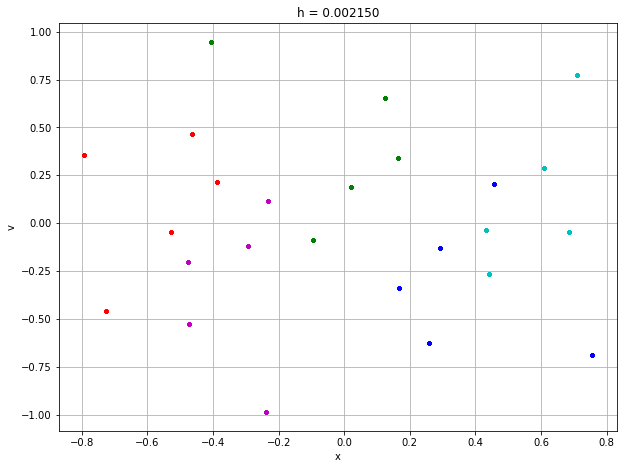

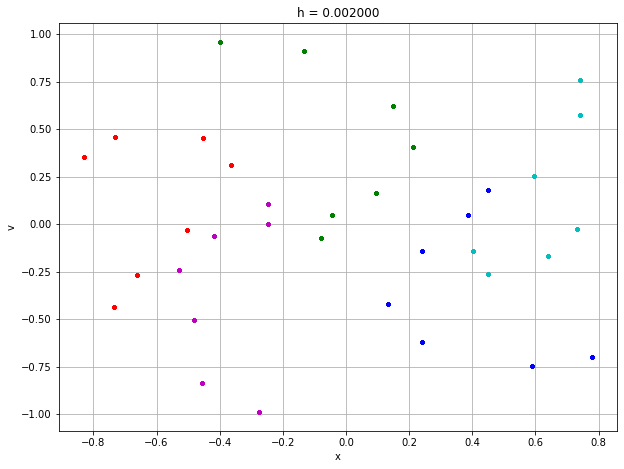

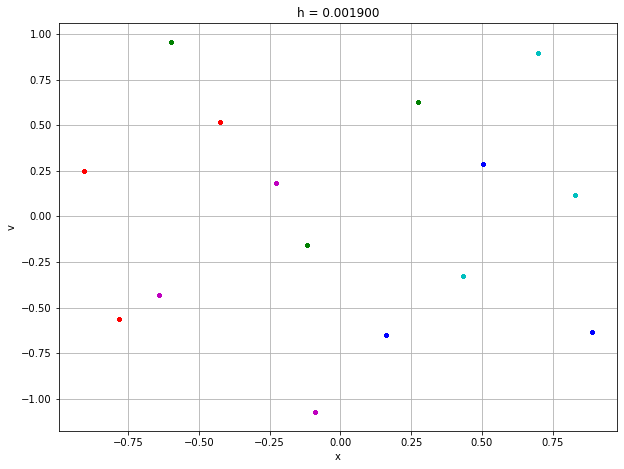

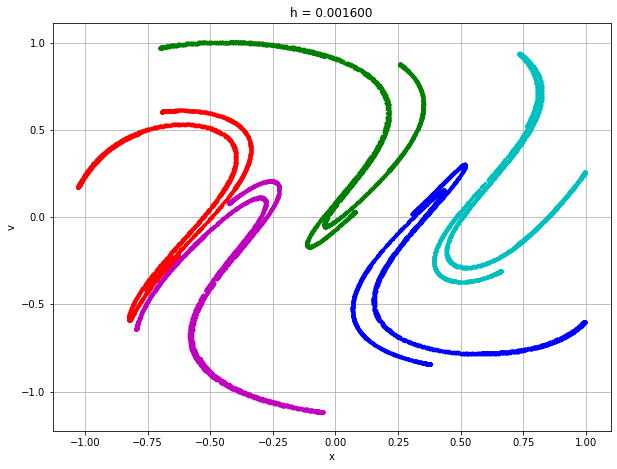

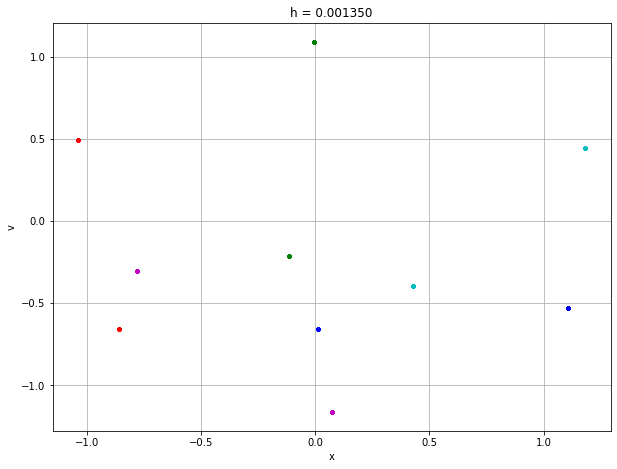

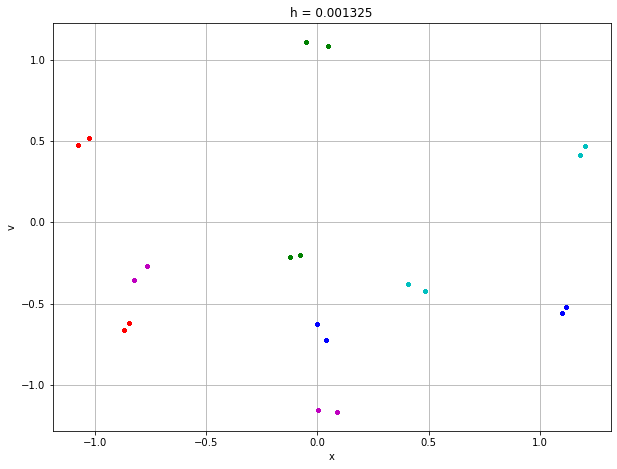

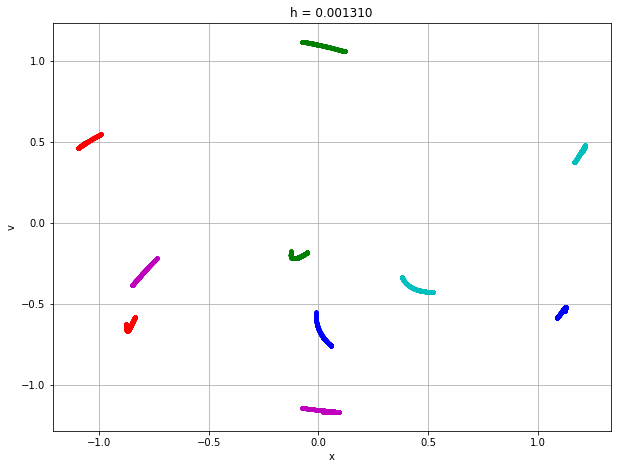

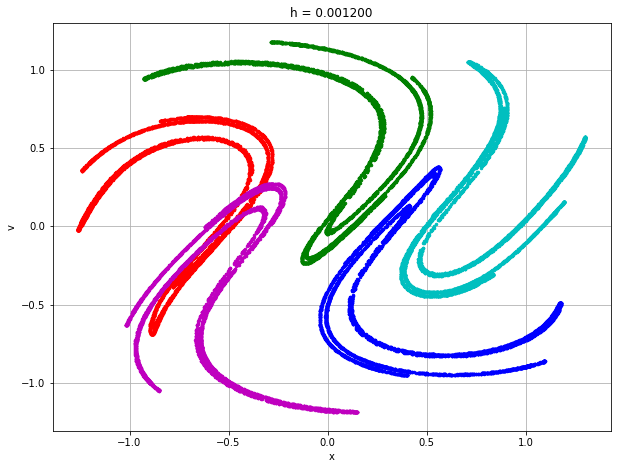

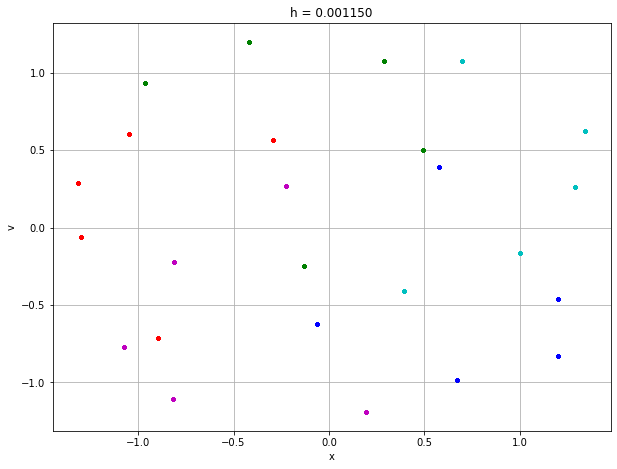

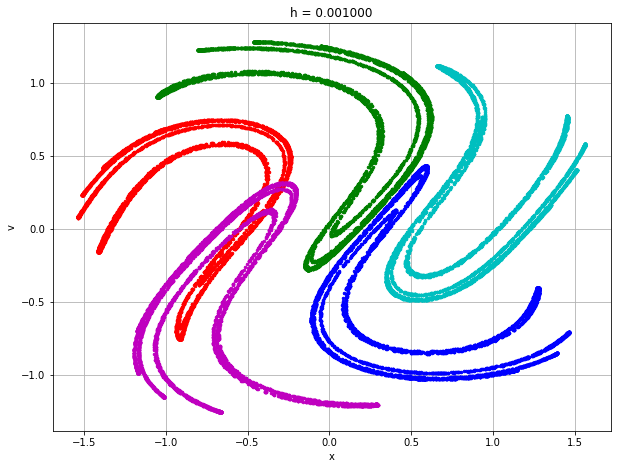

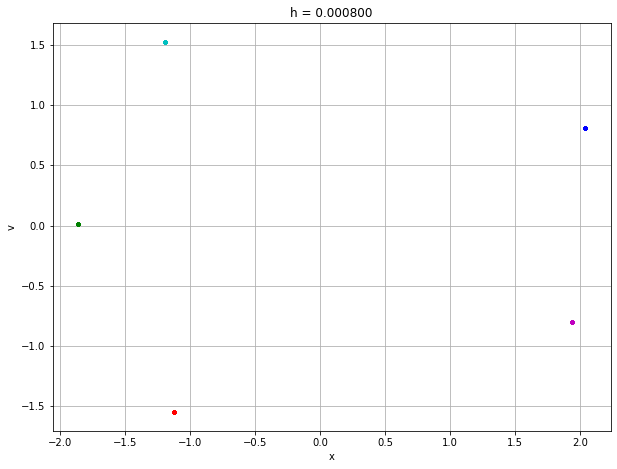

In [21]:
cols = ['b.', 'c.', 'g.', 'r.', 'm.']
for damp, sol in sols.items():
    for ph in range(len(cols)):
        first = presmp + ph * smpper // len(cols)
        plt.plot(sol[first::smpper, 1], sol[first::smpper, 0], cols[ph], markersize=5)
    plt.title("h = %f" % damp)
    plt.xlabel("x")
    plt.ylabel("v")
    plt.grid()
    plt.show()

Kui trajektoor on perioodiline, on punktide arv lõplik ja joonis näitab diskreetseid punkte. Kui trajektoor on mitteperioodiline, tekib igas generaatoriperioodis uus punkt, ja joonis on mittediskreetne.

## Sageduse spekter

Fourier teisenduse abil saame sageduse spektri arvutada. Antud juhul on meie jaoks huvitav vaid absoluutne amplituud konkreetse sageduse juures, seega arvutame võimsusspektri. Sageduse ühikuks tasub valida generaatori sagedust. Spekter näitab perioodide kahekordistumisi, kui tekib tipp vastava sageduse juures.

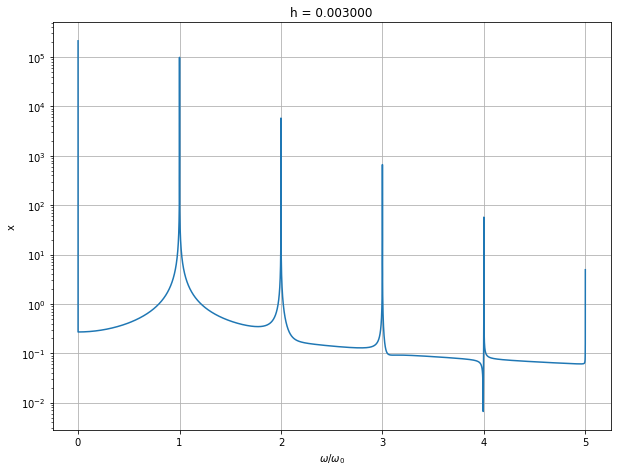

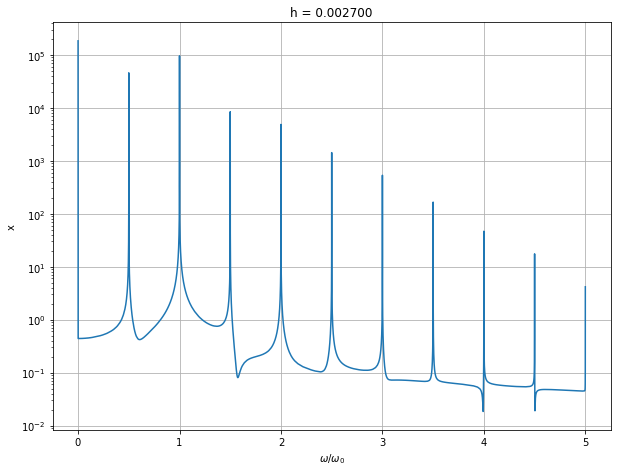

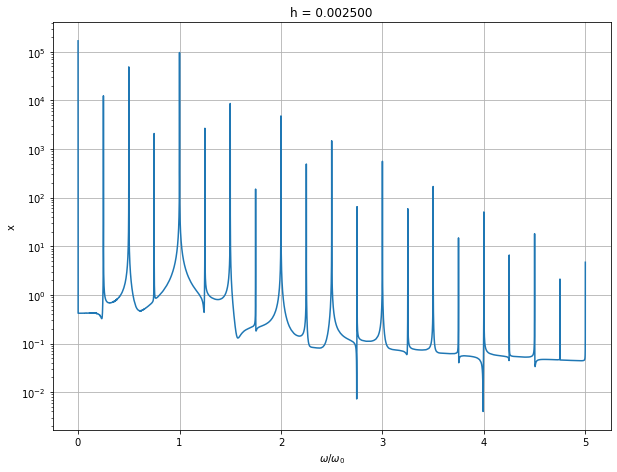

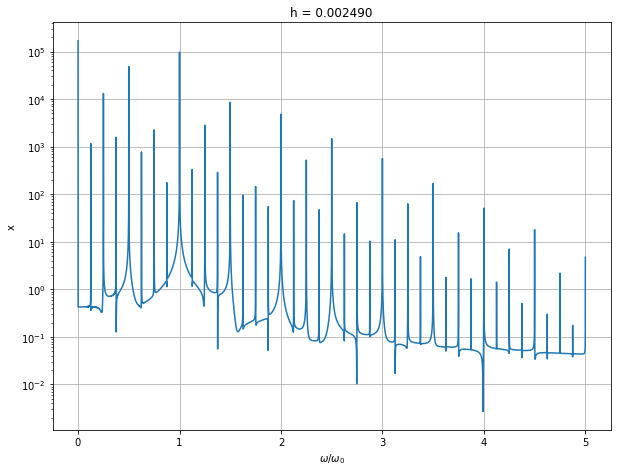

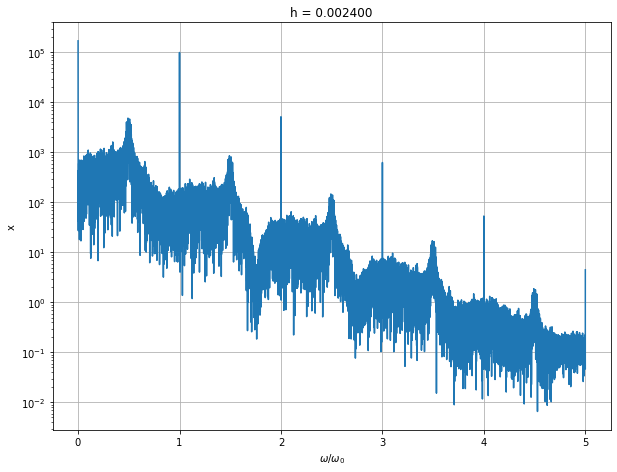

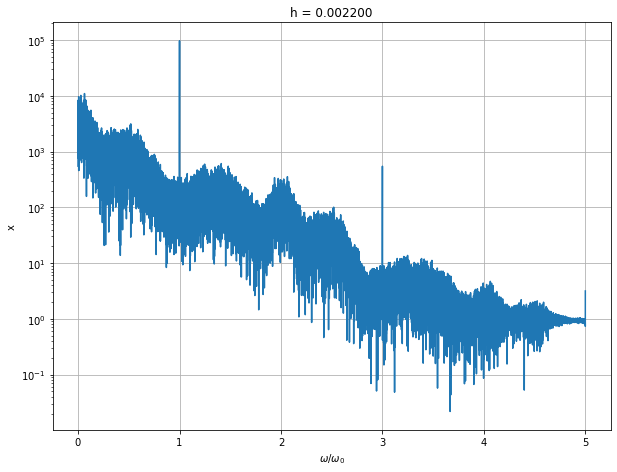

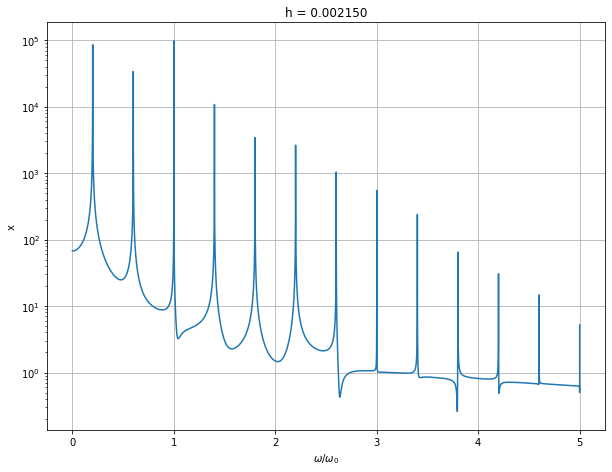

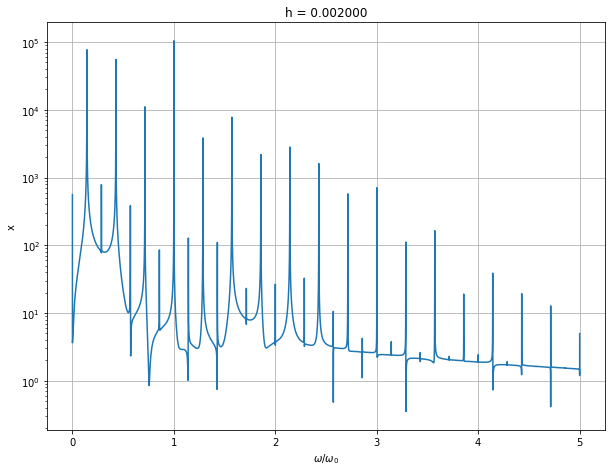

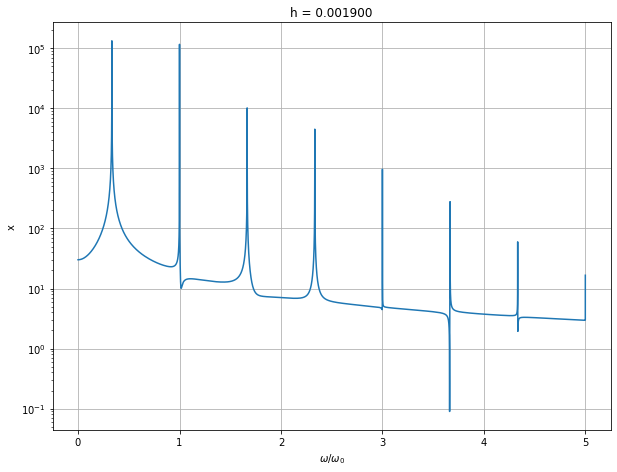

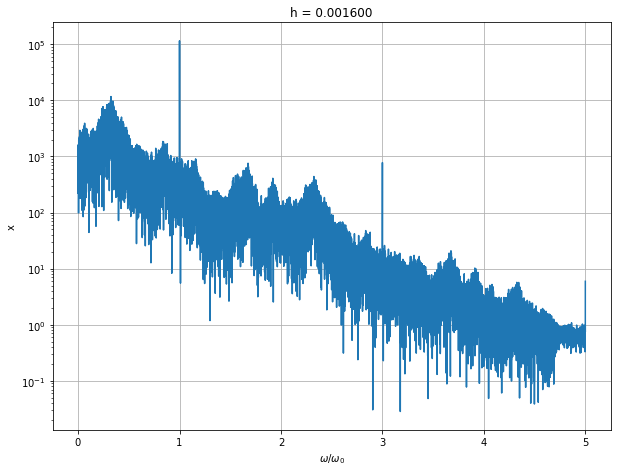

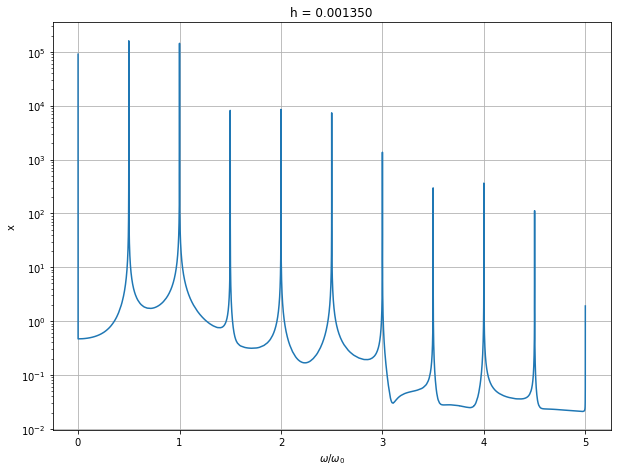

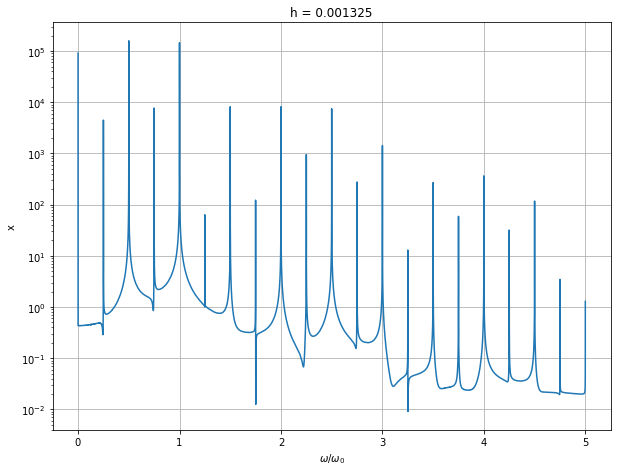

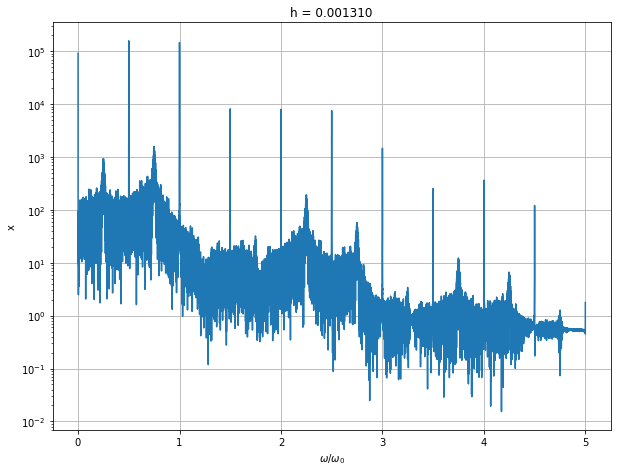

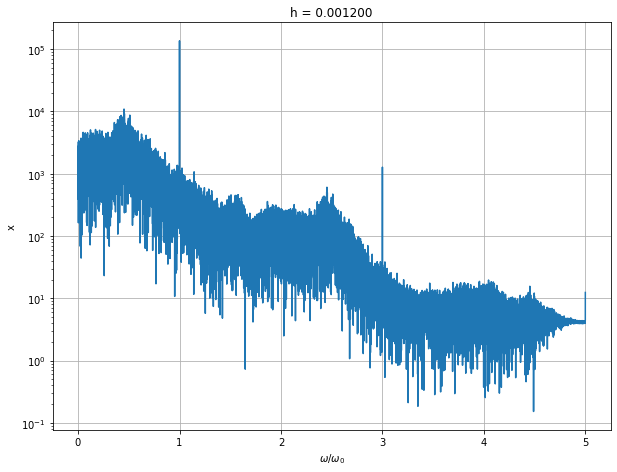

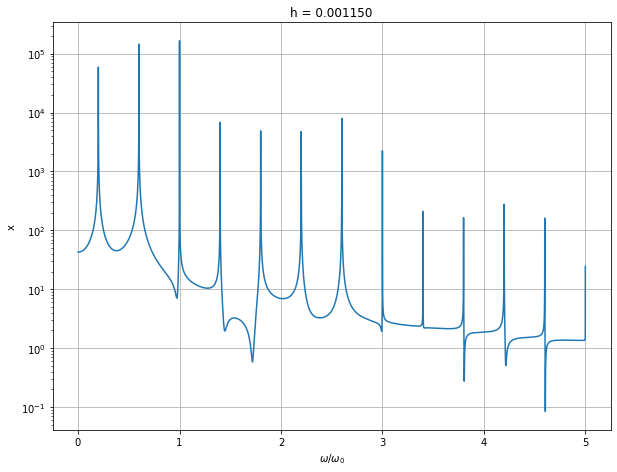

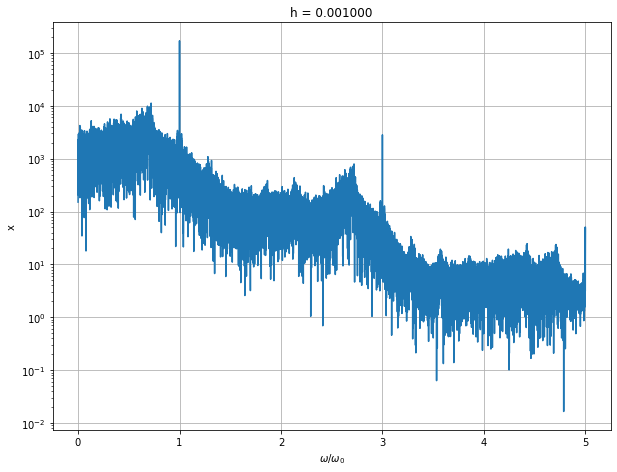

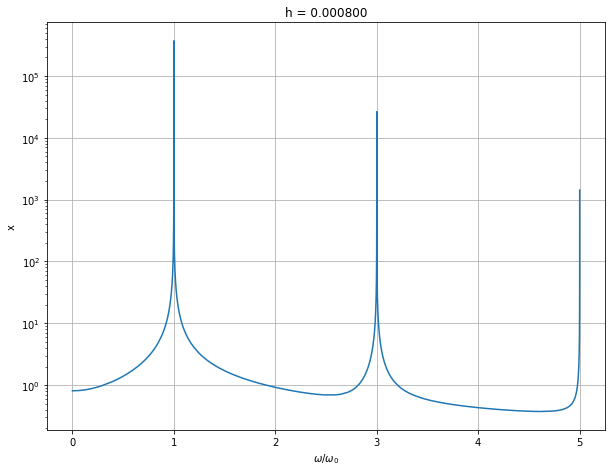

In [22]:
nfreqs = 5

fmax = nfreqs * (periods - perpre) + 1
freqs = np.linspace(0, nfreqs, fmax)

for damp, sol in sols.items():
    spec = np.absolute(np.fft.rfft(sol[presmp:, 0]))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_title("h = %f" % damp)
    ax.set_xlabel('$\\omega / \\omega_0$')
    ax.set_ylabel('x')
    ax.plot(freqs, spec[:fmax])
    ax.grid()
    plt.show()

## Feigenbaumi diagramm

Lõpuks joonistame Feigenbaumi diagrammi. Selleks simuleerime 1600 generaatori perioodi, ja joonistame neist vaid 200 viimast. Iga perioodi kohta simuleerime 100 ajasammu.

In [24]:
steps = 100
periods = 1600
samples = 200

nt = steps * periods
tmax = 2.0 * np.pi * periods / defparam['freq']
t = np.linspace(0, tmax, nt + 1)

Selle süsteemi huvitav parameetri vahemik on $h \in [0.0008, 0.003]$. Vahemikku jagame 1500 sammuks.

In [25]:
dampmax = 0.003
dampmin = 0.0008
ndamp = 1500

damps = np.linspace(dampmin, dampmax, ndamp + 1)
dplot = np.transpose(np.broadcast_to(damps, (samples, ndamp + 1))).flat

Süsteemi simuleerimiseks kasutame funktsiooni ```odeint```. See võtab aega!

In [28]:
dampint = pendint(y0, t, defparam, 'damp')

with mp.Pool() as pool:
    sol = np.array(pool.map(dampint, damps))

Tulemuse joonistamiseks kasutame funktsiooni ```scatter```. Siin on joonistatud nii asukoht kui kiirus, ja on valitud erinevad ajamisjõu faasid.

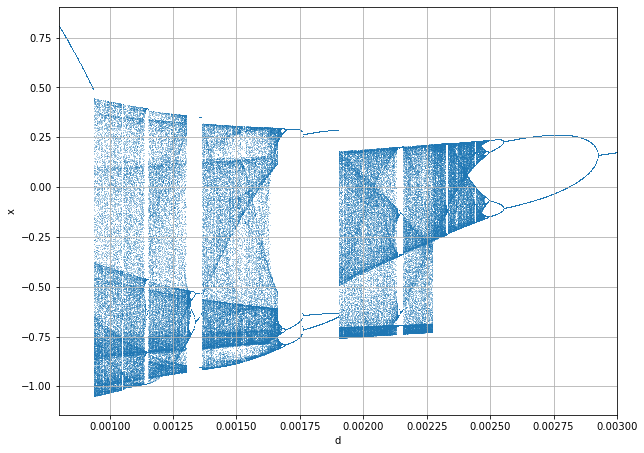

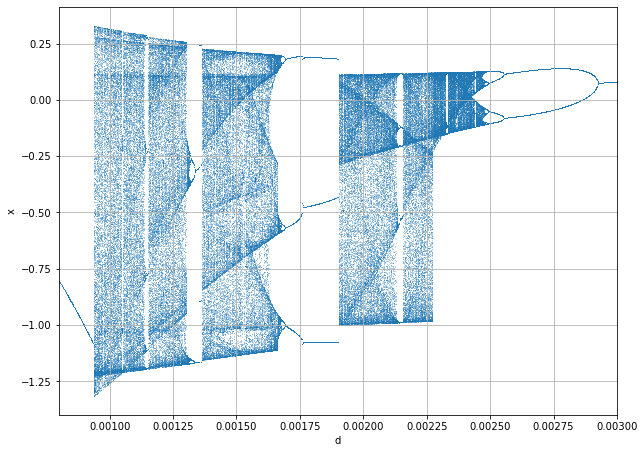

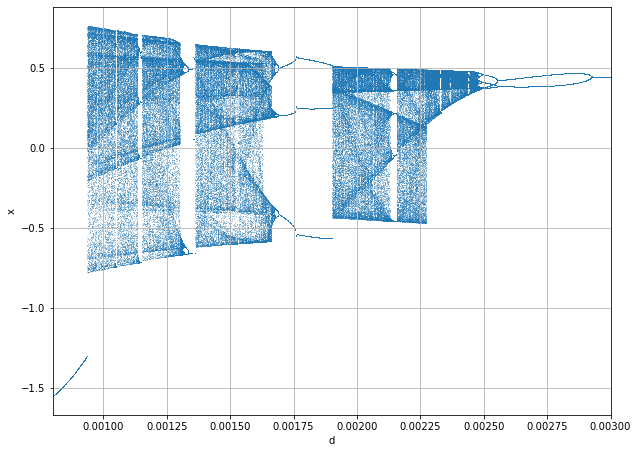

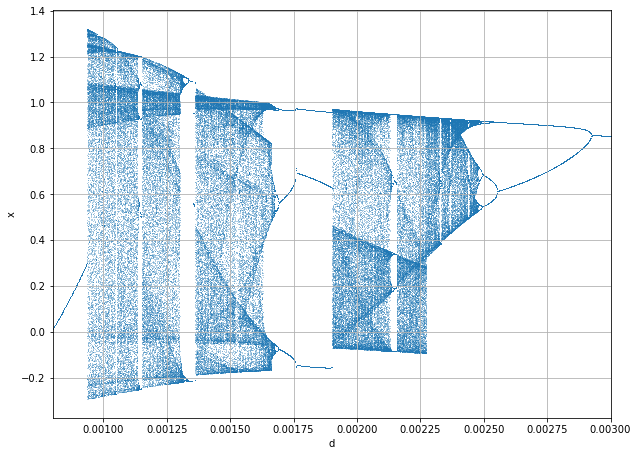

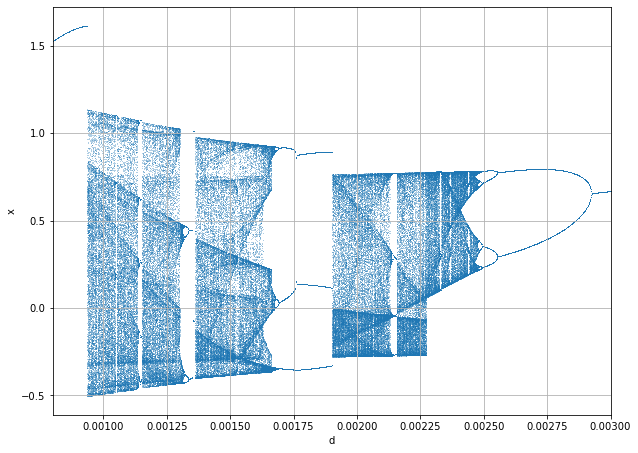

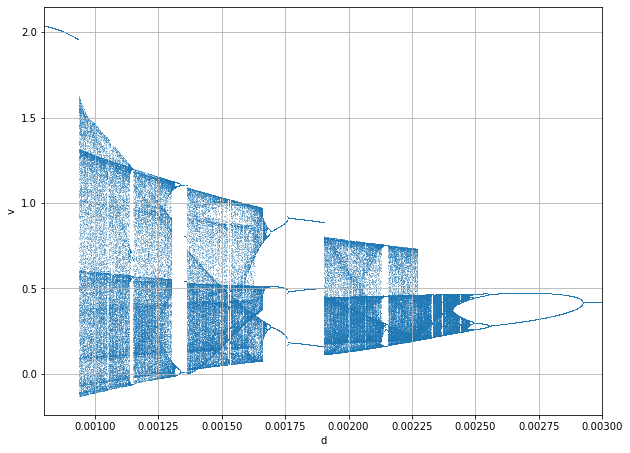

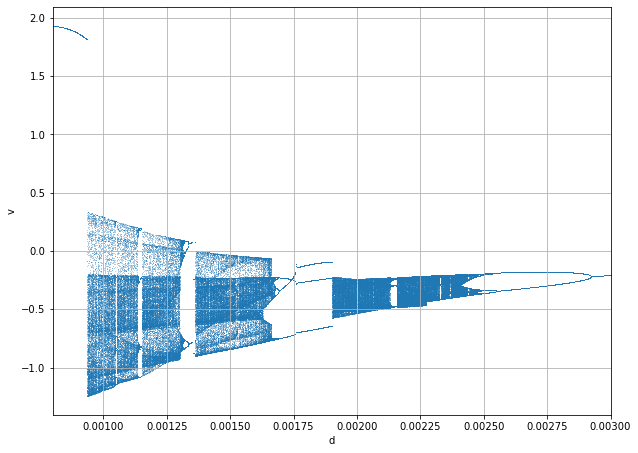

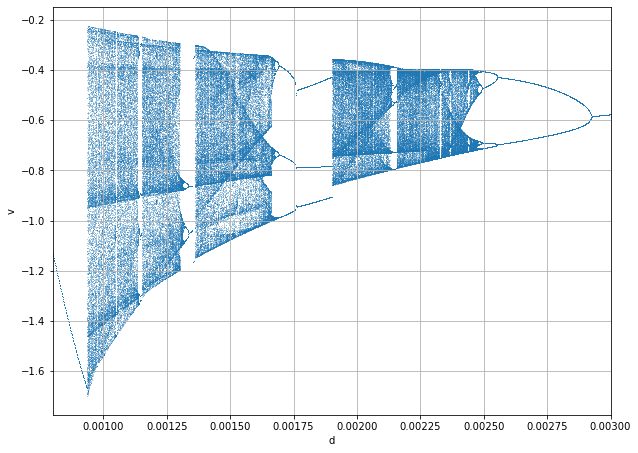

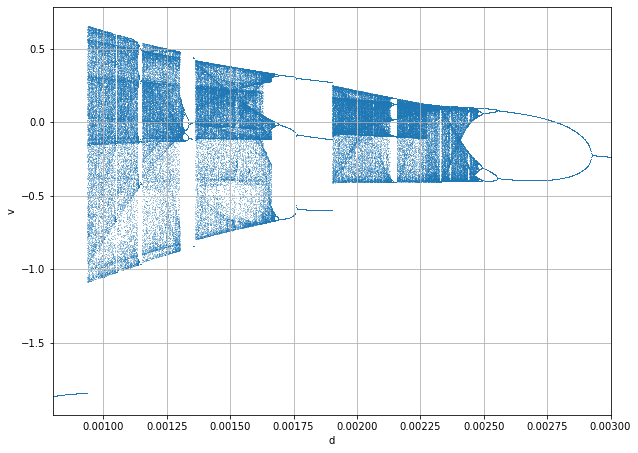

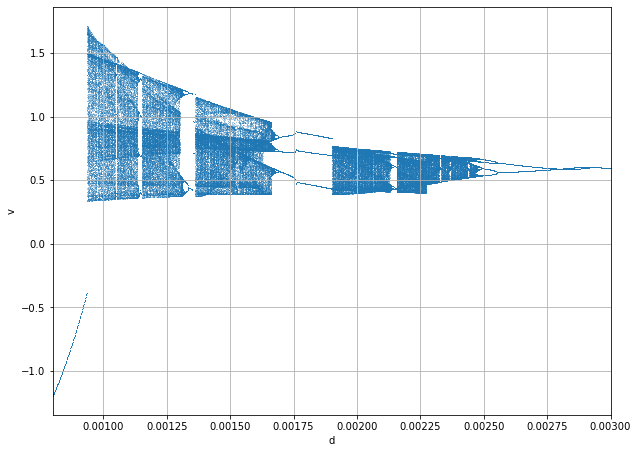

In [29]:
for var in [0, 1]:
    for phase in [0, 20, 40, 60, 80]:
        plt.scatter(dplot, sol[:, nt - steps * samples - phase:nt - phase:steps, var].flat, marker=".", s=1, lw=0)
        plt.xlabel("d")
        plt.ylabel(["x", "v"][var])
        plt.xlim(dampmin, dampmax)
        plt.grid()
        plt.show()

## Küsimused

### Faasiruumi mõõde

Milline on (autonoomse süsteemi) faasiruumi mõõde?

* <input id="dim1" name="dim" class="bad" type="radio"><label for="dim1">1</label>
* <input id="dim2" name="dim" class="bad" type="radio"><label for="dim2">2</label>
* <input id="dim3" name="dim" class="good" type="radio"><label for="dim3">3</label>
* <input id="dim4" name="dim" class="bad" type="radio"><label for="dim4">4</label>

### Võnkumise omadused

Milline väide on vale?

* <input id="typeA" name="type" class="bad" type="radio"><label for="typeA">Kui hõõrdetegur on väike, ületab pendel potentsiaalibarjääri $x = 0$.</label>
* <input id="typeB" name="type" class="bad" type="radio"><label for="typeB">Pendli liikumine järeldub unikaalselt dünaamikast ja algtingimustest.</label>
* <input id="typeC" name="type" class="bad" type="radio"><label for="typeC">Kui hõõrdetegur on sobivalt valitud, on pendli liikumisvõrranditel perioodilised lahendid.</label>
* <input id="typeD" name="type" class="good" type="radio"><label for="typeD">Trajektoorid faasiruumis lõikavad üksteist.</label>